In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from iwc2tb.GMI.gmiData import gmiData
from iwc2tb.GMI.GOES import GOES
import os
from mpl_toolkits.basemap import Basemap, cm
import numpy.ma as ma
from iwc2tb.common.hist2d import hist2d
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

In [2]:
batchSize          = 256
inputs             = ["ta", "lat", "stype"]
inputs1            = ["ta", "t0", "lat", "stype"]
outputs            = "wvp"
xlog               = True

latlims            = [45, 65]
validation_data    = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train.nc"), 
                             inputs1, 
                             outputs,
                             batch_size = batchSize,
                             latlims = latlims)

#quantiles1         = np.linspace(0.01, 0.99, 128)


STD  = validation_data.std
MEAN = validation_data.mean


validation_data_log    = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_test.nc"), 
                             inputs1, 
                             outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             std = STD,
                             mean = MEAN,
                             log = xlog)


quantiles1          = np.array([0.002, 0.03, 0.10, 0.16, 0.25, 0.34, 0.5, 0.66, 0.75, 0.84, 0.90, 0.97, 0.998])
quantiles          = np.arange(0.05, 1, 0.05)
imedian = np.argwhere((quantiles1 >= 0.50) & (quantiles1 < 0.51))[0][0]
imedian = np.argwhere(quantiles == 0.5)[0][0]

In [3]:
imedian

9

In [4]:
#qrnn =  QRNN.load(os.path.expanduser('~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_iwp_hlats_q.nc'))
qrnn_log    =  QRNN.load(os.path.expanduser('~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_wvp_hlats_log.nc'))

In [5]:
validation_data.std

masked_array(data=[21.6527156829834, 22.909250259399414,
                   13.289081573486328, 6.264140605926514,
                   10.979138374328613, 55.21819305419922,
                   1.4567347764968872],
             mask=[False, False, False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [6]:
def get_pos_mean(validation_data, qrnn, quantiles, log = False):
    y          = []
    y_pos_mean = []
    y_pre      = []
    x_in       = []

    nbatch = validation_data.__len__()
    for i in range(nbatch):

        xx, yy = validation_data.__getitem__(i)
        x = xx.detach().numpy() 
        y_pre.append(qrnn.predict(x)) 
        y_pos_mean.append((posterior_mean(x, qrnn, quantiles, log)))

        y.append(yy.detach().numpy())
        x_in.append(x)

    y_pre = np.concatenate(y_pre, axis = 0)
    y = np.concatenate(y, axis= 0)
    y_pos_mean = np.concatenate(y_pos_mean, axis = 0) 
    
    if log == True:
        y      = np.exp(y)
        y_pre  = np.exp(y_pre)
        
    return y, y_pre, y_pos_mean

def cdf(x, qrnn, quantiles, log = False):
    if len(x.shape) > 1:
        s = x.shape[:-1] + (quantiles.size + 2,)
    else:
        s = (1, quantiles.size + 2)

    y_pred = np.zeros(s)
    pre    = qrnn.predict(x)
    if log == True:
        pre = np.exp(pre)
    y_pred[:, 1:-1] = pre

    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(quantiles.size + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs


def posterior_mean(x, qrnn, quantiles, log = False):
    y_pred, qs = cdf(x, qrnn, quantiles, log)
    mus = y_pred[:, -1] - np.trapz(qs, x=y_pred)
    return mus


In [7]:

y1, y_pre1, y_pos_mean1 = get_pos_mean(validation_data_log, qrnn_log, quantiles, log = xlog)

In [8]:
y1.max()

45.38457

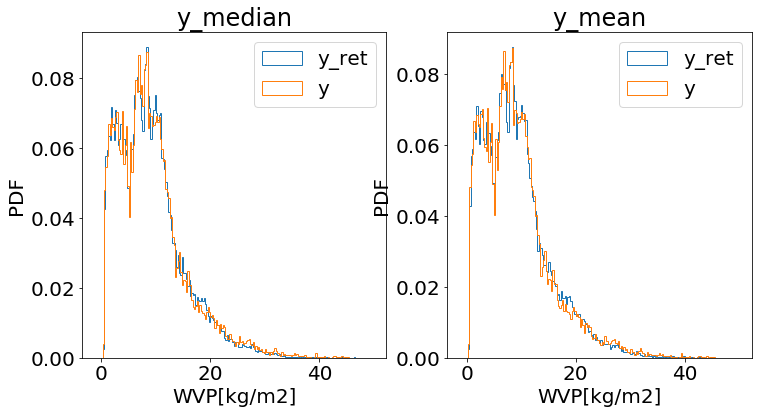

In [10]:
plt.rcParams.update({'font.size': 20})
bins1 = np.arange(-1, 50, 0.25)
fig, axes = plt.subplots(1, 2, figsize = [12, 6])
for ax, a, title in zip(axes.ravel(), 
                        [y_pre1[:, imedian], y_pos_mean1], 
                        ['y_median', 'y_mean']):
    
    ax.hist(a, bins1, density = True , histtype = "step", label = "y_ret")
    ax.hist(y1, bins1, density = True, histtype = "step", label = "y")
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_title(title)
    ax.legend()
    ax.set_ylabel("PDF")
    ax.set_xlabel("WVP[kg/m2]")
    fig.savefig("PDF_WVP.png", bbox_inches = "tight")

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Log scale: values of z <= 0 have been masked
/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Log scale: values of z <= 0 have been masked


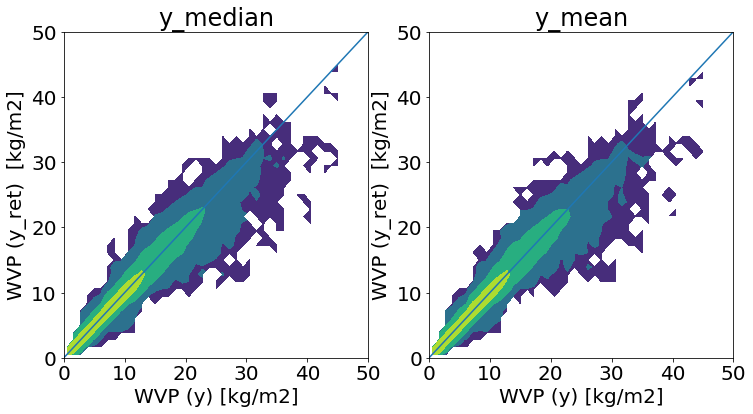

In [11]:
import scipy
from matplotlib import ticker, cm
xyrange = [[0, 50], [0, 50]] # data range
bins = [45, 45] # number of bins

fig, axes = plt.subplots(1, 2, figsize = [12, 6])
for ax, a, a0, title in zip(axes.ravel(), 
                     [y_pre1[:, imedian], y_pos_mean1], 
                     [y1, y1],
                    ['y_median', 'y_mean']):

    hh, locx, locy = np.histogram2d(a0, a, 
                                    range=xyrange, 
                                    bins=bins, density = True)

    posx = np.digitize(a0, locx)
    posy = np.digitize(a, locy)
    cs = ax.contourf(np.flipud(hh.T),
                    extent=np.array(xyrange).flatten(), 
                locator= ticker.LogLocator(), origin='upper')
    #cbar = fig.colorbar(cs)
    ax.set_ylim([0, 50])
    ax.set_xlim([0, 50])
    ax.set_title(title)
    xy = np.arange(0, 55, 1)
    yy = xy
    ax.plot(xy, yy)
    ax.set_ylabel("WVP (y_ret)  [kg/m2]")
    ax.set_xlabel("WVP (y) [kg/m2]")


In [12]:
from iwc2tb.common.plot_locations_map import plot_locations_map
import matplotlib.colors as colors
from matplotlib import cm

In [41]:
def plot_iwp(lat, lon, iwp0, iwp, iwp1, tb, mask):
    
    fig, ax = plt.subplots(1, 3, figsize = [20, 8])
    fig.tight_layout(pad=3.0)
    ax = ax.ravel()
    diff = 100 * (iwp1 - iwp0)/iwp0
    
    bbox = [np.min(lon),np.min(lat),np.max(lon),np.max(lat)] # set bounds for plotting
    n_add = 0
    m = Basemap(llcrnrlon=bbox[0]-n_add,llcrnrlat=bbox[1]-n_add,
                urcrnrlon=bbox[2]+n_add,urcrnrlat=bbox[3]+n_add,resolution='l',
                projection='cyl')
    x, y = m(lon, lat)    
    for var, axes, t in zip([iwp0, iwp1], ax, ["y", "y_mean"]):
        
        cs = axes.scatter(lon[mask],lat[mask], c = var[mask],
                          norm=colors.LogNorm(), vmin = 1, vmax = 50,
                         cmap = cm.Paired)
            
        #cs = m.scatter(lon, lat, var[mask]* 1000, ax = axes)    
        axes.set_title(t)
        ax[0].set_ylabel("Latitude [deg]")
        #axes.set_xlabel("Longitude [deg]")
    cs1 = ax[2].scatter(lon[mask],lat[mask], c = diff[mask],
                           vmin = -50, vmax = 50,
                         cmap = cm.coolwarm)    
    cbar = fig.colorbar(cs, ax=[ax[0], ax[1]])
    cbar.ax.set_ylabel("WVP [kg/m2]") 

    cbar = fig.colorbar(cs1, ax=ax[2])
    cbar.ax.set_ylabel("diff [%] ") 
    
    fig.savefig("WVP_retrieval.png", bbox_inches = "tight")
    

def get_mask(lat, lon, latlims, lonlims):
    
    im  = (lat >= latlims[0]) & (lat <= latlims[1])
    im1 = (lon >=  lonlims[0]) & (lon < lonlims[1])
    mask  = np.logical_and(im, im1)
    
    return mask    

def get_coords(validation_data):
    lat = validation_data.x[:, 5]
    lon = validation_data.lon%360
    tb  = validation_data.x[:, :5]
    stype = validation_data.x[:, -1]

    
    return lat, lon, tb, stype

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


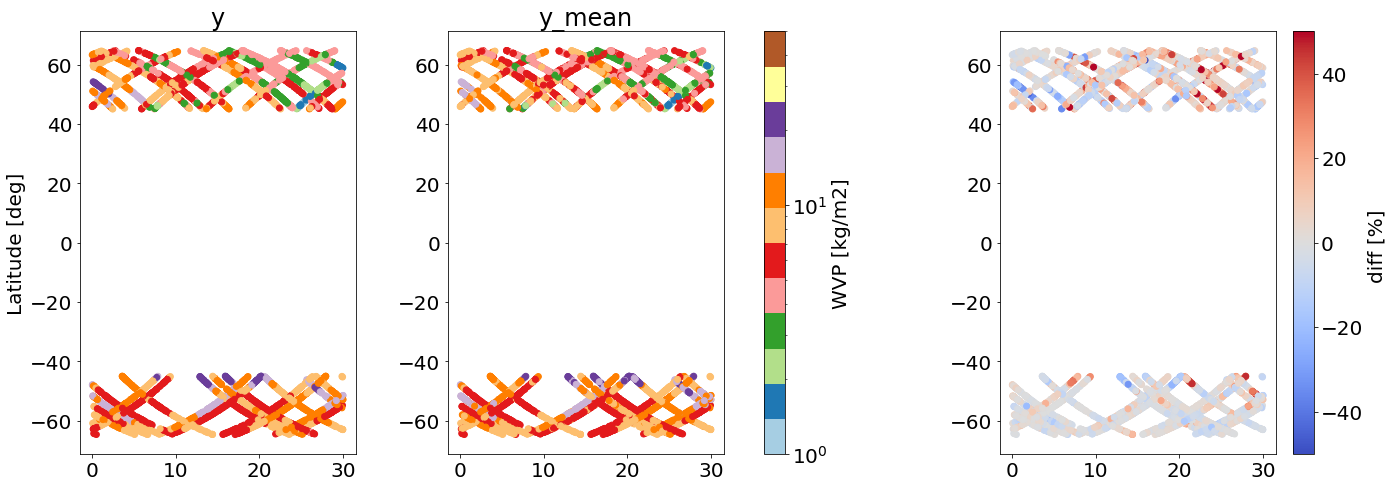

In [42]:
lat1,  lon1, tb1, stype1    = get_coords(validation_data_log)
lonlims = [0, 30]
latlims = [-65, 65]
mask1 = get_mask(lat1, lon1, latlims, lonlims)
plot_iwp(lat1, lon1, y1, y_pre1[:, imedian], y_pos_mean1, tb1, mask1) 


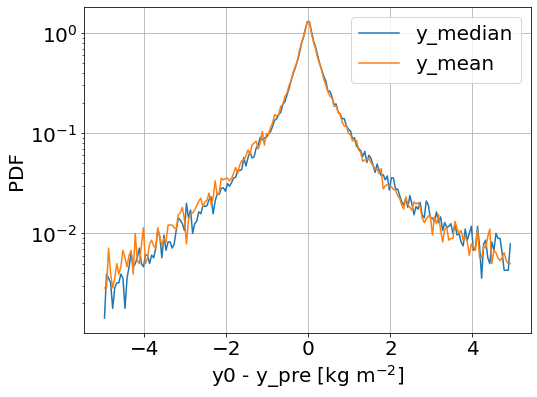

In [15]:
bins = np.arange(-5, 5, 0.05)
fig, ax = plt.subplots(1, 1, figsize = [8, 6])
hist_median, _ = np.histogram(y1 - y_pre1[:, imedian], bins, density = True)
hist_mean, _   = np.histogram(y1 - y_pos_mean1 , bins, density = True)
xbins = (bins[1:] + bins[:-1])/2.
ax.plot(xbins, hist_median, label = "y_median")
ax.plot(xbins, hist_mean, label = "y_mean")
ax.set_yscale('log')
ax.legend()
ax.set_xlabel("y0 - y_pre [kg m$^{-2}$]")
ax.set_ylabel("PDF")
plt.grid(True)
plt.show()
fig.savefig()

In [16]:
y.shape

NameError: name 'y' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
for i in range(1, 50000, 2000 ):
    ax.plot(quantiles, y_pre1[i, :], 'b', alpha = 0.2)
ax.set_xlabel("quantiles")
ax.set_ylabel("IWP")
fig.savefig("quantiles.png")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = [8, 8])
fig.tight_layout(pad=3.0)

for ax, ix, title in zip(axes.ravel(), [0, 1, 2, 3], ["water", "land", "snow", "sea-ice"]):
    mask = stype1 == ix
    ax.scatter(y1[mask], y_pos_mean1[mask])
    ax.set_title(title)
    ax.set_ylabel("Retrieved")
    ax.set_xlabel("Simulated") 

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Log scale: values of z <= 0 have been masked
/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Log scale: values of z <= 0 have been masked
/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


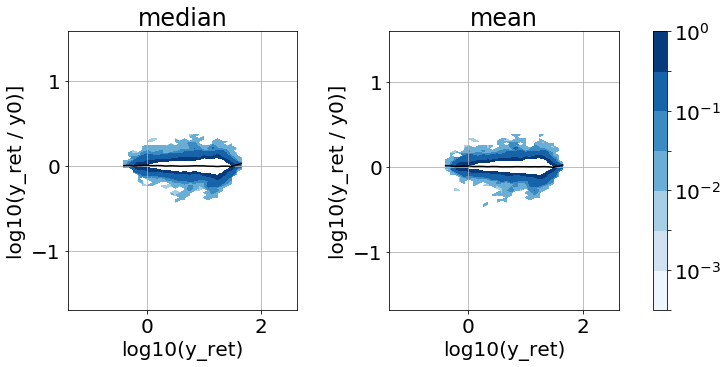

In [24]:
im = stype1 == 0
im1 = stype1 == 2
#xyrange = [[0, 3], [-5, 20]]
#xyrange = [[1e-5, 1e2], [1e-5, 1e20]]
bins = [50, 120]
xdat1 =  (np.log10(y_pos_mean1))
ydat1 = (np.log10((y_pos_mean1/y1)))

xdat = (np.log10(y_pre1[:, imedian]))
ydat = (np.log10((y_pre1[:, imedian]/y1)))


fig, axes = plt.subplots(1, 2, figsize = [12, 6])
fig.tight_layout(pad=3.0)    
for ax, xdt, ydt, title in zip(axes.ravel(), [xdat, xdat1], [ydat, ydat1], ["median", "mean"]):
        
        hh, xyrange, xdt1, ydt1 = hist2d(xdt, ydt, 
                                           bins = bins)
        cs = ax.contourf(np.flipud(hh.T), 
                         levels=[0.5e-3, 1e-3,  0.5e-2, 1e-2,  0.5e-1, 1e-1, 0.5,  1e0], 
                         cmap= 'Blues',
                extent=np.array(xyrange).flatten(), 
            locator= ticker.LogLocator(), origin='upper')
        
        
        hh, xyrange, xdt1, ydt1 = hist2d(xdt[im], ydt[im], 
                                           bins = bins, xyrange = xyrange)
#        cs1 = ax.contour(np.flipud(hh.T), 
#                         levels=[0.5e-3, 1e-3,  0.5e-2, 1e-2,  0.5e-1, 1e-1, 0.5,  1e0], 
#                         cmap= 'Reds',
#                extent=np.array(xyrange).flatten(), 
#            locator= ticker.LogLocator(), origin='upper')
        
        
#        hh, xyrange, xdt1, ydt1 = hist2d(xdt[im1], ydt[im1], 
#                                           bins = bins, xyrange = xyrange)
#        cs1 = ax.contour(np.flipud(hh.T), 
#                         levels=[0.5e-3, 1e-3,  0.5e-2, 1e-2,  0.5e-1, 1e-1, 0.5,  1e0], 
#                         cmap= 'Greens',
#                extent=np.array(xyrange).flatten(), 
#            locator= ticker.LogLocator(), origin='upper')
        

        hh, locx, locy = np.histogram2d(xdt, ydt, range = xyrange,
                                     bins = bins, density = True)
        dy = 0.5 * (locy[1:] + locy[:-1])
        dx = 0.5 * (locx[1:] + locx[:-1])
        off = []

        for i in range(50):
            a = np.sum(dy * hh[i, :])
            b = np.sum(hh[i, :])
            off.append(a/b)
        off = np.stack(off)    
        ax.plot(dx, off, 'k')

        ax.grid('on')

        ax.set_ylabel(r"log10(y_ret / y0)]")
        ax.set_xlabel(r"log10(y_ret)")
        ax.set_title(title)
cbar = fig.colorbar(cs, ax = axes)        

In [17]:
def mfe( y0, y):
    return np.median(10**(np.abs(np.log10(y/y0))) - 1) * 100

def calculate_mfe(y0, y):
    nbins = 45
    logbins = np.log10(np.logspace(np.log10(1e-10), np.log10(1e2), nbins))
    ibins = np.digitize(np.log10(y0), logbins)
    err = []
    for ix in range(nbins):

        ix = np.where(ibins == ix)[0]

        err.append(mfe(y0[ix], y[ix]))
    return err, logbins

In [18]:
err, logbins  = calculate_mfe(y1, y_pos_mean1)
err1, _ = calculate_mfe(y1, y_pre1[:, imedian])

/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


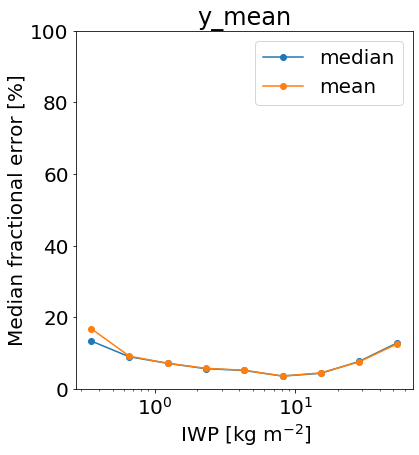

In [19]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
fig.tight_layout(pad=1.0)   

ax.plot(10 **(logbins[1:]), err1[1:], '-o', label = "median")
ax.plot(10 ** (logbins[1:]), err[1:], '-o', label = "mean")
ax.set_ylim([0, 100])
ax.set_xscale("log")
ax.set_title(title)
ax.set_xlabel(r" IWP [kg m$^{-2}$] ")
ax.set_ylabel("Median fractional error [%]")
ax.legend()    

In [20]:
def rmse(y, y0):
    return np.sqrt(np.mean((y - y0)**2))

def mae(y, y0):
    return np.mean(np.abs(y - y0))

def bias(y, y0):
    return np.mean(y - y0)

[1.8820773, 1.6753536, 0.7478933, 0.67347074, 1.2697102]
[-0.18668447, 0.132529, -0.06513224, -0.01319263, -0.035732]


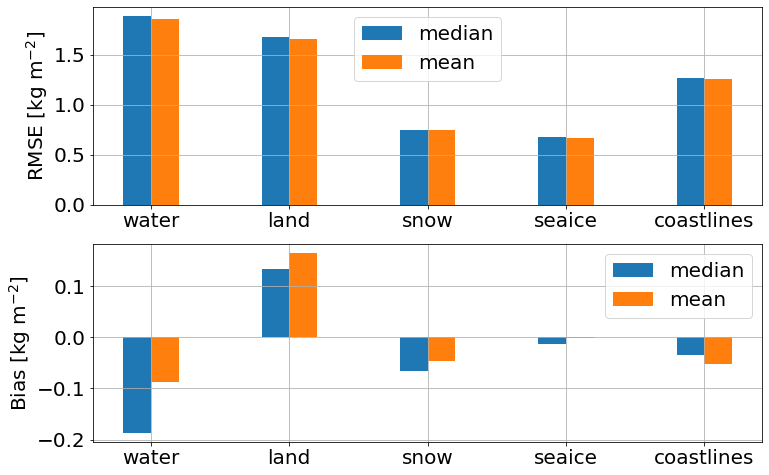

In [43]:
rms = []
rms1 = []

bs = []
bs1 = []
stypes = ["water", "land", "snow", "seaice", "coastlines"]
for ix in [0, 1, 2, 3, 4]:
    im = stype1 == ix

    rms.append(rmse(y_pre1[im, imedian], y1[im]))
    rms1.append(rmse(y_pos_mean1[im], y1[im]))
    
    bs.append(bias(y_pre1[im, imedian], y1[im]))
    bs1.append(bias(y_pos_mean1[im], y1[im]))

fig, axes = plt.subplots(2, 1, figsize = [12, 8])
x = np.arange(len(stypes))  # the label locations
width = .20  # the width of the bars
for ax, r, b in zip(axes.ravel(), [rms, bs], [rms1, bs1]):
    print(r)
    ax.bar(x - width/2, r, width = width, label = "median", color = "tab:blue")
    ax.bar(x + width/2, b, width = width, label = "mean", color = "tab:orange")
    ax.set_xticks(x)
    ax.set_xticklabels(stypes)
    ax.legend()
    ax.grid("on")
axes[0].set_ylabel(r"RMSE [kg m$^{-2}$]")
axes[1].set_ylabel(r"Bias [kg m$^{-2}$]")
fig.savefig("statistics_WVP.png", bbox_inches = "tight")

(100,) (91,) (57323,)


/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


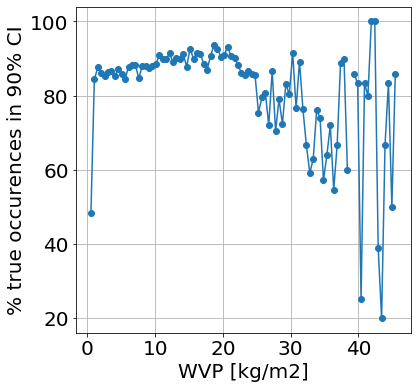

In [44]:
nbins = 100
bins = np.linspace(0, 50, nbins)
ibins = np.digitize(y1, bins)
counts = np.bincount(ibins)


ntrue = []

for j in range(nbins):
    itrue = ([i for i in range(y1.shape[0]) if y1[i] >= y_pre1[i, 0] if y1[i] <= y_pre1[i, -1] if ibins[i] == j])
    ntrue.append(len(itrue))
ntrue = np.array(ntrue)

print(ntrue.shape, counts.shape, ibins.shape)

fig, ax = plt.subplots(1, 1, figsize = [6, 6])

nx = counts.shape[0]
ax.plot(bins[:nx], 100 * ntrue[:nx]/counts, '-o')
#ax.set_xscale("log")
ax.set_xlabel("WVP [kg/m2]")
ax.set_ylabel("% true occurences in 90% CI")
ax.grid('on')
fig.savefig("true_occurences.png", bbox_inches = "tight") 

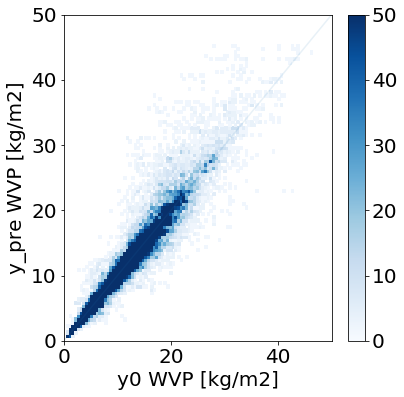

In [45]:

ibins_p = np.digitize(y_pos_mean1, bins)

imatrix = np.zeros([nbins, nbins])
ibins_p = np.digitize(y_pos_mean1, bins)


for i in range(ibins.max()):
    try:
        in2 = ibins_p[ibins == i].max()
        ib = np.bincount(ibins_p[ibins == i ])
        imatrix[i, :in2 + 1] = 100 * ib/np.sum(ibins == 1)
    except:
        continue
imatrix[imatrix == 0] = np.nan        
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
cs = ax.pcolormesh(bins, bins, imatrix, cmap='Blues', vmin = 0, vmax = 50)
#ax.set_yscale('log')
#ax.set_xscale('log')
x = bins
y = x
ax.plot(x, y, alpha = 0.1)
fig.colorbar(cs)
ax.set_xlabel("y0 WVP [kg/m2]")
ax.set_ylabel("y_pre WVP [kg/m2]")  
fig.savefig("histogram2d_WVP.png", bbox_inches = "tight")

In [30]:
bins

array([ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202,
        2.52525253,  3.03030303,  3.53535354,  4.04040404,  4.54545455,
        5.05050505,  5.55555556,  6.06060606,  6.56565657,  7.07070707,
        7.57575758,  8.08080808,  8.58585859,  9.09090909,  9.5959596 ,
       10.1010101 , 10.60606061, 11.11111111, 11.61616162, 12.12121212,
       12.62626263, 13.13131313, 13.63636364, 14.14141414, 14.64646465,
       15.15151515, 15.65656566, 16.16161616, 16.66666667, 17.17171717,
       17.67676768, 18.18181818, 18.68686869, 19.19191919, 19.6969697 ,
       20.2020202 , 20.70707071, 21.21212121, 21.71717172, 22.22222222,
       22.72727273, 23.23232323, 23.73737374, 24.24242424, 24.74747475,
       25.25252525, 25.75757576, 26.26262626, 26.76767677, 27.27272727,
       27.77777778, 28.28282828, 28.78787879, 29.29292929, 29.7979798 ,
       30.3030303 , 30.80808081, 31.31313131, 31.81818182, 32.32323232,
       32.82828283, 33.33333333, 33.83838384, 34.34343434, 34.84